In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from Symbol import SYMBOLS
from distances import MINDIST
import warnings 
from dtw import dtw
from sklearn.model_selection import GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

from SAX_transf import *


warnings.filterwarnings('ignore')
import os
import aeon
from aeon.datasets import load_classification

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
train_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TRAIN.ts")
test_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TEST.ts")

X_train = pd.read_csv(train_path, 
                      sep=",", 
                      header=None
                      )

X_train.columns = list(X_train.columns[:-1]) + ['label']
x_train, y_train = X_train.iloc[:, :-1], X_train["label"]

y_train = y_train.replace(-1, 0)

X_test = pd.read_csv(test_path, 
                      sep=",", 
                      header=None
                      )

X_test.columns = list(X_test.columns[:-1]) + ['label']
x_test, y_test = X_test.iloc[:, :-1], X_test["label"]

y_test = y_test.replace(-1, 0)

In [35]:
test_serie_centered = x_test.iloc[0] - x_test.iloc[0].mean()
sax_trans = SAX_transform(test_serie_centered, 20, 5)
D_sax_rep = sax_trans.transf_1d_sax(8, 8)
D_sax_rep


[63, 40, 52, 16, 8, 0, 0, 5, 7, 31, 55, 51, 50, 45, 41, 40, 34, 36, 47, 26]

In [36]:
def reconstruct_from_1d_sax_test(OneD_SAX, Na, Ns):
    """
    Reconstructs an approximation of the time series from its 1d-SAX representation.
    
    OneD_SAX: List of symbols representing the 1d-SAX representation.
    Na: Number of quantization levels for average values.
    Ns: Number of quantization levels for slope values.
    
    Returns:
        - A list representing the reconstructed time series.
    """
    # On recalcule les breakpoints
    num_segments = len(OneD_SAX)
    avg_breakpoints = norm.ppf(np.linspace(0, 1, Na + 1)[1:-1], loc=0, scale=1)
    slope_variance = 0.03 / num_segments
    slope_breakpoints = norm.ppf(np.linspace(0, 1, Ns + 1)[1:-1], loc=0, scale=np.sqrt(slope_variance))
    print(slope_breakpoints, avg_breakpoints)

    reconstructed_series = []
    segment_size = len(test_serie_centered) // num_segments

    for symbol in OneD_SAX:

        # Par construction de 1d-SAX, on peut retrouver les symboles de la moyenne et de la pente
        avg_symbol = symbol >> int(np.log2(Ns))
        slope_symbol = symbol & (Ns - 1)

        if avg_symbol == 0: 
            approx_avg = avg_breakpoints[0]
        elif avg_symbol == Na - 1:
            approx_avg = avg_breakpoints[-1]
        else:
            approx_avg = (avg_breakpoints[avg_symbol - 1] + avg_breakpoints[avg_symbol]) / 2 

        if slope_symbol == 0:
            approx_slope = slope_breakpoints[0]
        elif slope_symbol == Ns - 1:
            approx_slope = slope_breakpoints[-1]
        else:
            approx_slope = (slope_breakpoints[slope_symbol - 1] + slope_breakpoints[slope_symbol]) / 2 

        segment = [approx_avg + approx_slope * (t - 1) for t in range(1, segment_size + 1)]
        reconstructed_series.extend(segment)

    return reconstructed_series

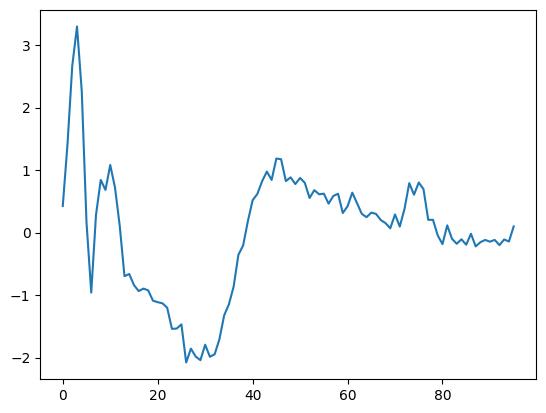

In [37]:
plt.plot(test_serie_centered)

[-0.03259585 -0.00981209  0.00981209  0.03259585] [-1.64485363 -1.28155157 -1.03643339 -0.84162123 -0.67448975 -0.52440051
 -0.38532047 -0.2533471  -0.12566135  0.          0.12566135  0.2533471
  0.38532047  0.52440051  0.67448975  0.84162123  1.03643339  1.28155157
  1.64485363]


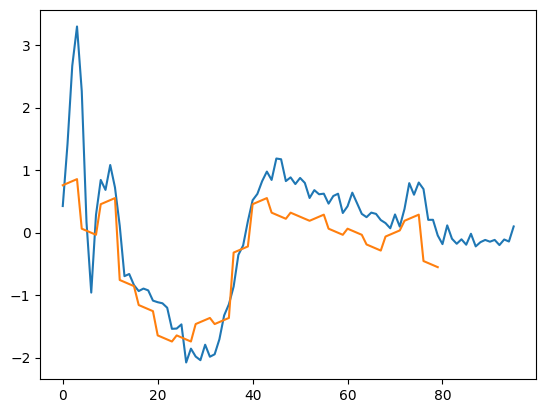

In [38]:
reconstructed_serie = reconstruct_from_1d_sax_test(D_sax_rep, 20, 5)

plt.plot(test_serie_centered)
plt.plot(reconstructed_serie)
plt.show()